<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# KNN Classification and Imputation: Cell Phone Churn Data

_Authors: Kiefer Katovich (SF)_

---

In this lab you will practice using KNN for classification (and a little bit for regression as well).

The dataset is one on "churn" in cell phone plans. It has information on the usage of the phones by different account holders and whether or not they churned or not.

Our goal is to predict whether a user will churn or not based on the other features.

We will also be using the KNN model to **impute** missing data. There are a couple of columns in the dataset with missing values, and we can build KNN models to predict what those missing values will most likely be. This is a more advanced imputation method than just filling in the mean or median.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from sklearn.neighbors import KNeighborsClassifier

### 1. Load the cell phone "churn" data containing some missing values.

In [2]:
churn = pd.read_csv('../data/churn_missing.csv')

### 2. Examine the data. What columns have missing values?

In [3]:
churn.head(3)

,state,account_length,area_code,intl_plan,vmail_plan,vmail_message,day_mins,day_calls,day_charge,eve_mins,eve_calls,eve_charge,night_mins,night_calls,night_charge,intl_mins,intl_calls,intl_charge,custserv_calls,churn
0,KS,128,415,no,yes,25.0,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,no,yes,26.0,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,no,no,0.0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False


In [4]:
churn.shape

(3333, 20)

In [5]:
churn.isnull().sum()

state               0
account_length      0
area_code           0
intl_plan           0
vmail_plan        400
vmail_message     400
day_mins            0
day_calls           0
day_charge          0
eve_mins            0
eve_calls           0
eve_charge          0
night_mins          0
night_calls         0
night_charge        0
intl_mins           0
intl_calls          0
intl_charge         0
custserv_calls      0
churn               0
dtype: int64

In [6]:
# about 12% ofvmail plan & message are null

In [7]:
churn.dtypes

state              object
account_length      int64
area_code           int64
intl_plan          object
vmail_plan         object
vmail_message     float64
day_mins          float64
day_calls           int64
day_charge        float64
eve_mins          float64
eve_calls           int64
eve_charge        float64
night_mins        float64
night_calls         int64
night_charge      float64
intl_mins         float64
intl_calls          int64
intl_charge       float64
custserv_calls      int64
churn                bool
dtype: object

In [8]:
churn.intl_plan.value_counts(dropna=False)

no     3010
yes     323
Name: intl_plan, dtype: int64

In [9]:
churn.vmail_plan.value_counts(dropna=False)

no     2130
yes     803
NaN     400
Name: vmail_plan, dtype: int64

In [10]:
churn.state.value_counts()

WV    106
MN     84
NY     83
AL     80
WI     78
OH     78
OR     78
WY     77
VA     77
CT     74
MI     73
ID     73
VT     73
TX     72
UT     72
IN     71
KS     70
MD     70
MT     68
NJ     68
NC     68
NV     66
WA     66
CO     66
MS     65
RI     65
MA     65
AZ     64
MO     63
FL     63
NM     62
ME     62
ND     62
DE     61
OK     61
NE     61
SC     60
SD     60
KY     59
IL     58
NH     56
AR     55
DC     54
GA     54
TN     53
HI     53
AK     52
LA     51
PA     45
IA     44
CA     34
Name: state, dtype: int64

In [11]:
#Note: DC is being counted as a state

### 3. Convert the `vmail_plan` and `intl_plan` colums to binary integer columns.

Make sure that if a value is missing that you don't fill it in with a new value! Preserve the missing values.

In [12]:
churn.loc[:,'vmail_plan'] = churn.vmail_plan.map(lambda x: 1 if x == 'yes' else 0 if x == 'no' else x)
churn.loc[:,'intl_plan'] = churn.intl_plan.map(lambda x: 1 if x == 'yes' else 0 if x == 'no' else x)

### 4. Create dummy coded columns for state and concatenate it to the churn dataset.

> **Remember:** You will need to leave out one of the state dummy coded columns to serve as the "reference" column since we will be using these for modeling.

In [13]:
states = pd.get_dummies(churn.state, drop_first=True)
states.head(3)
# drop_first removed Alaska(AK) from being converted to a dummy column

,AL,AR,AZ,CA,CO,CT,DC,DE,FL,GA,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
states.shape

(3333, 50)

In [15]:
print len(churn.state.unique())

51


In [16]:
churn = pd.concat([churn, states], axis=1)

### 5. Create a version of the churn data that has no missing values.

Calculate the shape

In [17]:
churn_nona = churn.dropna()
churn_nona.shape

(2933, 70)

### 6. Create a target vector and predictor matrix.

- Target should be the `churn` column.
- Predictor matrix should be all columns except `area_code`, `state`, and `churn`.

In [18]:
X =churn_nona.drop(['area_code','state','churn'], axis =1)
y = churn_nona.churn.values

### 7. Calculate the baseline accuracy for `churn`.

In [19]:
churn_nona.churn.mean()
# Less than 0.5

0.14353903852710534

In [20]:
baseline = 1. - churn_nona.churn.mean()
print baseline

0.856460961473


### 8. Cross-validate a KNN model predicting `churn`. 

- Number of neighbors should be 5.
- Make sure to standardize the predictor matrix.
- Set cross-validation folds to 10.

Report the mean cross-validated accuracy.

In [21]:
knn = KNeighborsClassifier(n_neighbors=5)

In [22]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

In [23]:
ss = StandardScaler()
Xs = ss.fit_transform(X)

In [24]:
scores = cross_val_score(knn, Xs, y, cv=10)
print scores
print np.mean(scores)

[ 0.84745763  0.86054422  0.86006826  0.85665529  0.87030717  0.85665529
  0.85665529  0.85324232  0.85665529  0.85665529]
0.857489604276


### 9. Iterate from k=1 to k=49 (only odd k) and cross-validate the accuracy of the model for each.

Plot the cross-validated mean accuracy for each score. What is the best accuracy?

In [25]:
k_values = range(1,50,2)
accs = []
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, Xs, y, cv=10)
    accs.append(np.mean(scores))

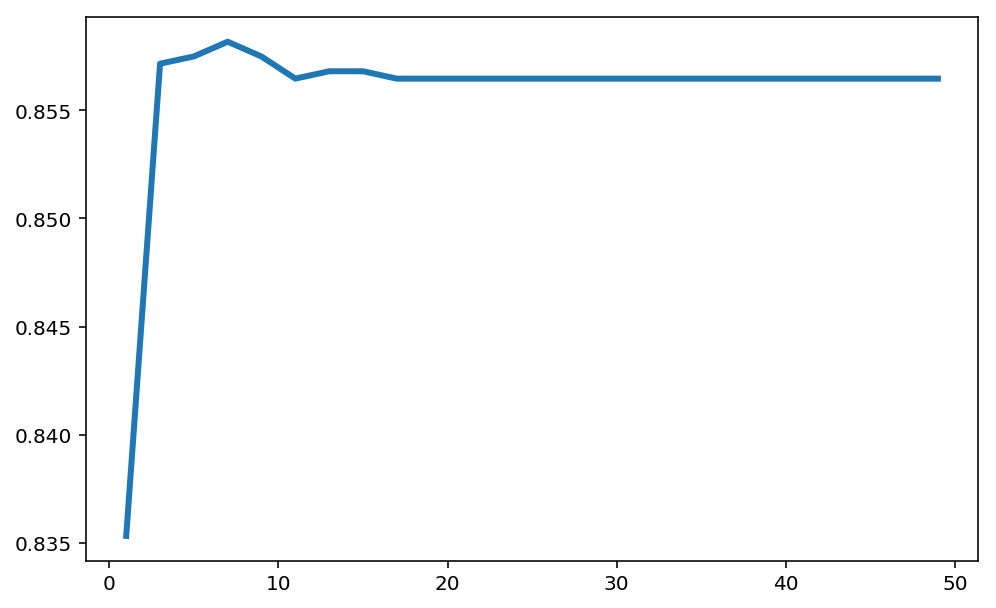

0.858169892125


In [26]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(k_values, accs, lw=3)
plt.show()

print np.max(accs)

In [27]:
# looks like there is a peak at about k=7 and then levels out after k=17

### 10. Imputing with KNN

K-Nearest Neighbors can be used to impute missing values in datasets. What we will do is estimate the most likely value for the missing data based on a KNN model.

We have two columns with missing data:
- `vmail_plan`
- `vmail_message`

**10.A: Create two subsets of the churn dataset: one without missing values for `vmail_plan` and `vmail_message`, and one with the missing values.**

In [28]:
from sklearn.neighbors import KNeighborsRegressor
missing_cols = ['vmail_plan','vmail_message']

In [29]:
impute_missing = churn.loc[churn.vmail_plan.isnull(), :]
impute_valid = churn.loc[~churn.vmail_plan.isnull(), :]

First we will impute values for `vmail_plan`. This is a categorical column and so we will impute using classification (predicting whether the plan is yes or no, 1 vs. 0).

**10.B: Create a target that is `vmail_plan` and predictor matrix that is all columns except `state`, `area_code`, `churn`, `vmail_plan`, and `vmail_message`.**

> **Note:** We don't include the `churn` variable in the model to impute. Why? We are imputing these missing values so that we can use the rows to predict churn with more data afterwards. If we imputed with churn as a predictor then we would be cheating.

In [30]:
impute_cols = [c for c in impute_valid.columns if not c in ['state','area_code','churn']+missing_cols]
y = impute_valid.vmail_plan.values
X = impute_valid[impute_cols]

**10.C: Standardize the predictor matrix.**

In [31]:
ss = StandardScaler()
Xs = ss.fit_transform(X)

In [32]:
X.columns

Index([u'account_length', u'intl_plan', u'day_mins', u'day_calls',
       u'day_charge', u'eve_mins', u'eve_calls', u'eve_charge', u'night_mins',
       u'night_calls', u'night_charge', u'intl_mins', u'intl_calls',
       u'intl_charge', u'custserv_calls', u'AL', u'AR', u'AZ', u'CA', u'CO',
       u'CT', u'DC', u'DE', u'FL', u'GA', u'HI', u'IA', u'ID', u'IL', u'IN',
       u'KS', u'KY', u'LA', u'MA', u'MD', u'ME', u'MI', u'MN', u'MO', u'MS',
       u'MT', u'NC', u'ND', u'NE', u'NH', u'NJ', u'NM', u'NV', u'NY', u'OH',
       u'OK', u'OR', u'PA', u'RI', u'SC', u'SD', u'TN', u'TX', u'UT', u'VA',
       u'VT', u'WA', u'WI', u'WV', u'WY'],
      dtype='object')

**10.D: Find the best K for predicting `vmail_plan`.**

You may want to write a function for this. What is the accuracy for predicting `vmail_plan` at the best K? What is the baseline accuracy for `vmail_plan`?

In [33]:
def find_best_k_cls(X, y, k_min=1, k_max=51, step=2, cv=5):
    k_range = range(k_min, k_max+1, step)
    accs = []
    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X, y, cv=cv)
        accs.append(np.mean(scores))
    print np.max(accs), np.argmax(k_range)
    return np.argmax(k_range)

In [34]:
find_best_k_cls(Xs, y)

0.726219395201 25


25

In [35]:
impute_valid.vmail_plan.mean()
# less than 0.5

0.27378111148994205

In [36]:
vmail_plan_baseline = 1. - impute_valid.vmail_plan.mean()
print vmail_plan_baseline

0.72621888851


In [37]:
# we can already see that out calculated baseline is practically
# identical to the best CV score which leads us down the path
# to believe that there would be very little knowledge gain from
# said model

**10.E: Fit a `KNeighborsClassifier` with the best number of neighbors.**

In [38]:
knn = KNeighborsClassifier(n_neighbors=25)
knn.fit(Xs, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=25, p=2,
           weights='uniform')

**10.F: Predict the missing `vmail_plan` values using the subset of the data where it is misssing.**

You will need to:
1. Create a new predictor matrix using the same predictors but from the missing subset of data.
- Standardize this predictor matrix *using the StandardScaler object fit on the non-missing data*. This means you will just use the `.transform()` function. It is important to standardize the new predictors the same way we standardized the original predictors if we want the predictions to make sense. Calling `.fit_transform()` will reset the standardized scale.
- Predict what the missing vmail plan values should be.
- Replace the missing values in the original with the predicted values.

> **Note:** It may predict all 0's. This is OK. If you want to see the predicted probabilities of `vmail_plan` for each row you can use the `.predict_proba()` function instead of `.predict()`.  You can use these probabilities to manually set the criteria threshold.

In [39]:
X_miss = impute_missing[impute_cols]
X_miss_s = ss.transform(X_miss)

In [40]:
vmail_plan_impute = knn.predict(X_miss_s)

In [41]:
vmail_plan_impute

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

In [42]:
# creating a DF copy to use to imputed missing values
churn_imputed = churn.copy()
# filling missing vmail_plan values with those predicted by KNN model
churn_imputed.loc[churn.vmail_plan.isnull(), 'vmail_plan'] = vmail_plan_impute

### 11. Impute the missing values for `vmail_message` using the same process.

Since `vmail_message` is essentially a continuous measure, you need to use `KNeighborsRegressor` instead of the `KNeighborsClassifier`.

KNN can do both regression and classification! Instead of "voting" on the class like in classification, the neighbors will average their value for the target in regression.


In [43]:
def find_best_k_reg(X, y, k_min=1, k_max=51, step=2, cv=10):
    k_range = range(k_min, k_max+1, step)
    r2s = []
    for k in k_range:
        knn = KNeighborsRegressor(n_neighbors=k)
        scores = cross_val_score(knn, X, y, cv=cv)
        r2s.append(np.mean(scores))
    print np.max(r2s), np.argmax(k_range)
    return np.argmax(k_range)

In [44]:
# x-true & y-true
y = impute_valid.vmail_message.values
X = impute_valid[impute_cols]

# set and fit the scaler
ss = StandardScaler()
Xs = ss.fit_transform(X)

# call/use find k-best function on known data
best_k = find_best_k_reg(Xs, y)

# apply k-best to fit model
knn = KNeighborsRegressor(n_neighbors=best_k)
knn.fit(Xs, y)

# prepair rows with missing target values
X_miss = impute_missing[impute_cols]
X_miss_s = ss.transform(X_miss)

# use model to predict unknown values
vmail_message_impute = knn.predict(X_miss_s)
vmail_message_impute

# this r2 is not very good

-0.0349364182016 25


array([  7.68,   8.28,   5.36,   8.48,  10.68,   6.  ,   8.68,   8.08,
         9.32,   7.8 ,   9.72,   3.8 ,   8.88,   4.2 ,   2.44,  11.72,
         8.04,   6.88,   8.08,   7.84,  11.76,   7.56,   8.12,  11.84,
         5.16,   9.88,  15.48,  10.04,   6.76,  11.72,   7.96,   7.68,
         8.92,   8.88,   6.4 ,   7.36,   9.72,  10.04,  11.  ,   5.16,
        10.96,   7.4 ,   4.92,  11.4 ,  10.36,  10.56,   7.08,   8.72,
         9.28,   6.24,   8.92,   7.84,  12.24,   6.84,   4.24,  10.8 ,
         5.72,   5.92,   4.76,   8.72,   6.88,   8.32,   6.92,   9.04,
         7.36,   9.2 ,   5.48,   2.92,   4.  ,  11.2 ,   9.36,   7.84,
         7.76,   3.6 ,   8.2 ,   9.32,  10.2 ,   8.08,   7.8 ,  10.12,
         7.64,  12.08,   8.52,   3.28,   8.72,   7.  ,   2.8 ,   9.12,
         6.36,   9.2 ,  11.88,   9.  ,   7.84,  10.8 ,   9.44,   5.72,
        10.36,  10.52,   3.72,   8.8 ,   4.72,   6.32,   8.36,   5.44,
         6.8 ,   4.04,   3.88,   3.4 ,   4.88,   5.28,   1.68,   9.28,
      

In [45]:
# assign predicted values to missing values in dataframe
churn_imputed.loc[churn.vmail_message.isnull(), 'vmail_message'] = vmail_message_impute

### 12. Given the accuracy (and $R^2$) of your best imputation models when finding the best K neighbors, do you think imputing is a good idea?

In [46]:
# The accuracy and R2 are very bad. This our imputed values are most likely wrong with these models.
# This doesn't necessarily mean that imputation is a bad idea, but we may want to consider
# using a different method.

### 13. With the imputed dataset, cross-validate the accuracy predicting churn. Is it better? Worse? The same?

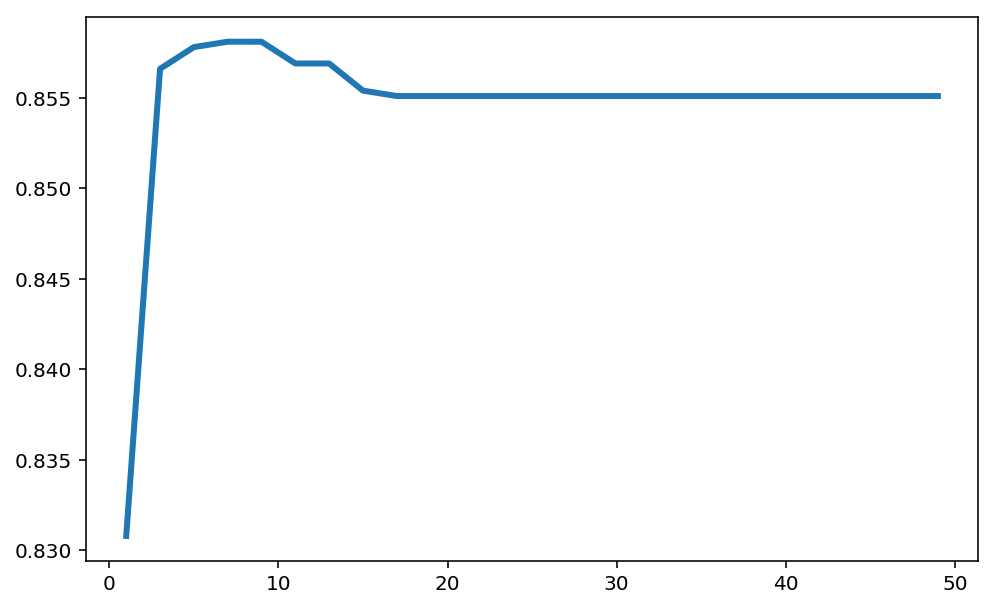

In [47]:
X = churn_imputed[[c for c in churn_nona.columns if not c in ['area_code','state','churn']]]
y = churn_imputed.churn.values

ss = StandardScaler()
Xs = ss.fit_transform(X)

k_values = range(1,50,2)
accs = []
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, Xs, y, cv=10)
    accs.append(np.mean(scores))
    
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(k_values, accs, lw=3)
plt.show()

In [48]:
print np.max(accs)

0.858089226952


In [49]:
# Its basically exactly the same. 
# However the peak performance comes at about k=9
# Given that our model using imputed data scores almost exactly the same
# and requires more neighbors to come reach optimal accuracy
# we would either want to investigate other means of imputation
# or
# utilize the original model as it is computationally more efficient.